In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append("..")

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from typing import Tuple
from inpainting.custom_layers import Reshape
import pandas as pd

In [9]:
class IrisInpainter(
    nn.Module
):
    def __init__(self, n_mixes: int = 1, in_size: int = 4, a_width = 3):
        super().__init__()

        
        self.extractor = nn.Sequential(
            nn.Linear(in_size * 2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
        )
        
        self.a_extractor = nn.Sequential(
            nn.Linear(20, in_size * n_mixes * a_width),
            Reshape((-1, n_mixes, a_width, in_size,)) # * L, we don't want 1x4 vector but L x4 matrix))
        )
        self.m_extractor = nn.Sequential(
            nn.Linear(20, n_mixes * in_size),
            Reshape((-1, n_mixes, in_size))

        )
        
        self.d_extractor = nn.Sequential(
            nn.Linear(20, n_mixes * in_size),
            Reshape((-1, n_mixes, in_size))

        )
        
        self.p_extractor = nn.Sequential(
            nn.Linear(20, n_mixes),
            nn.Softmax()
        ) # omit this, let's say p = 1 for now

    def forward(self, X, J):
        X_masked = X * J
        X_J = torch.cat([X_masked, J], dim=1)
        features = self.extractor(X_J)
        m = self.m_extractor(features)
        d = self.d_extractor(features)
        p = self.p_extractor(features)
        a = self.a_extractor(features)
        
        return  p, m, a, d

In [10]:

def nll_loss(X, J, P, M, A, D) -> torch.autograd.Variable:
    zipped = zip(X, J, P, M, A, D)
    losses = []
    
    
    for i, (x, j, p, m, a, d) in enumerate(zipped):
        mask_inds = (j==0).nonzero().squeeze()
        x_masked = torch.index_select(x, 0, mask_inds)
        a_masked = torch.index_select(a, 2, mask_inds)
        m_masked, d_masked = [
            torch.index_select(t, 1, mask_inds)
            for t in [m, d]
        ]
        
        for (p_i, m_i, d_i, a_i) in zip(p, m_masked, d_masked, a_masked):
            if a_i.shape[1] > 0:
                cov = (a_i.T @ a_i) + torch.diag(d_i ** 2)
                mvn_d = dist.MultivariateNormal(m_i, cov) # calculate this manually
                l = - mvn_d.log_prob(x_masked) 
                losses.append(l)
            else:
                losses.append(torch.autograd.Variable(torch.tensor(0.0), requires_grad=True))
    return torch.stack(losses).mean()

In [58]:
def experiment(thresh: float) -> Tuple[float, float, float]:
    iris = datasets.load_iris()
    X = iris['data']
    y = iris['target']
    np.random.seed(0)
    J = np.random.uniform(size=X.shape)
    J[J < thresh] = 0
    J[J >= thresh] = 1
    X_train, X_test, J_train, J_test, y_train, y_test = train_test_split(X, J, y, test_size=0.33, random_state=0)
    ds_train = TensorDataset(
        torch.Tensor(X_train), 
        torch.Tensor(J_train),
        torch.Tensor(y_train).long()
    )

    ds_test = TensorDataset(
        torch.Tensor(X_test), 
        torch.Tensor(J_test),
        torch.Tensor(y_test).long()
    )

    batch_size=16
    dl_train = DataLoader(ds_train, batch_size, shuffle=True)
    dl_test = DataLoader(ds_test, batch_size, shuffle=True)
    
    
    inpainter = IrisInpainter()
    opt = optim.Adam(inpainter.parameters(), lr=4e-3)
    n_epochs = 100
    train_hist = []
    val_hist = []
    for e in range(n_epochs):
        inpainter.train()
        train_losses = [] 
        for i, (x, j, y) in enumerate(dl_train):
            inpainter.zero_grad()
            p, m, a, d = inpainter(x, j)
            loss = nll_loss(x, j, p, m, a, d)
            loss.backward()
            opt.step()
            train_losses.append(loss)
        train_hist.append(torch.stack(train_losses).mean())

        inpainter.eval()
        val_losses = []
        for i, (x, j, y) in enumerate(dl_test):
            inpainter.zero_grad()
            p, m, a, d = inpainter(x, j)
            loss = nll_loss(x, j, p, m, a, d)
            val_losses.append(loss)
        val_hist.append(torch.stack(val_losses).mean())

    #     print(train_hist[-1], val_losses[-1])
    
    
    full_classifier = MLPClassifier((10, 20, 10, 4), learning_rate_init=4e-3, max_iter=1000, random_state=0 ).fit(X_train, y_train)
    full_full_acc = accuracy_score(full_classifier.predict(X_test), y_test)
    
    X_test_masked = X_test * J_test
    full_masked_acc = accuracy_score(full_classifier.predict(X_test_masked), y_test)
    
    X_train_masked = X_train * J_train
    masked_classifier =  MLPClassifier((10, 20, 10, 4), learning_rate_init=4e-3, max_iter=1000, random_state=0 ).fit(
        np.hstack([X_train_masked, J_train]), y_train
    )
    masked_full_acc = accuracy_score(masked_classifier.predict(np.hstack([X_test, np.ones_like(X_test)])), y_test)
    masked_masked_acc = accuracy_score(masked_classifier.predict(np.hstack([X_test_masked, J_test])), y_test)
    
    
    P_test, M_test, A_test, D_test = inpainter(torch.Tensor(X_test_masked), torch.Tensor(J_test))

    X_test_inpainted = X_test_masked.copy()
    X_test_inpainted[J_test == 0] = M_test.detach().numpy()[:, 0][J_test == 0]
    full_inp_acc = accuracy_score(full_classifier.predict(X_test_inpainted), y_test)
    masked_inp_acc = accuracy_score(masked_classifier.predict(np.hstack([X_test_inpainted, np.ones_like(X_test_inpainted)])), y_test)
    return {
        "thresh": thresh,
        "full_full": full_full_acc,
        "full_masked": full_masked_acc,
        "masked_full": masked_full_acc,
        "masked_masked": masked_masked_acc,
        "full_inp_acc": full_inp_acc,
        "masked_inp_acc": masked_inp_acc
    }
    

In [59]:
results = pd.DataFrame([
    experiment(thresh)
    for thresh in np.linspace(0.1, 1, 10)
])

/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/mprzewie/.anaconda3/envs/uj/li

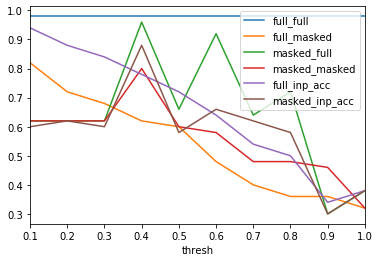

In [60]:
results.plot("thresh", [c for c in results.columns if c != "thresh"],)
